# Liberalised Power Markets — Bonus Assignment

Place CSV files in a folder named `Data/` next to this notebook.

In [ ]:
# Imports & setup
import os
import math
import shutil
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp

def read_input_data(data_dir="Data"):
    nodes = 5
    demand_data = np.zeros((nodes, 24, 4, 3), dtype=float)          # Dimensions: (node, hour, season, scenario)
    wind_data   = np.zeros((nodes, 24, 4, 3), dtype=float)
    node_labels   = ["N1", "N2", "N3", "N4", "N5"]                  # Header for nodes
    season_labels = ["Winter", "Spring", "Summer", "Autumn"]        # Header for seasons
    old_cwd = os.getcwd()
    os.makedirs(data_dir, exist_ok=True)
    try:
        os.chdir(data_dir)
        for i, nlab in enumerate(node_labels):                      # Nodes
            for j, slab in enumerate(season_labels):                # Seasons
                df_d = pd.read_csv(f"D_{nlab}_{slab}.csv")
                df_w = pd.read_csv(f"W_{nlab}_{slab}.csv")
                demand_data[i, :, j, 0] = df_d["Min"].values        # ":" is numpy notation for "all elements"
                demand_data[i, :, j, 1] = df_d["Mean"].values
                demand_data[i, :, j, 2] = df_d["Max"].values
                wind_data[i, :, j, 0]   = df_w["Min"].values
                wind_data[i, :, j, 1]   = df_w["Mean"].values
                wind_data[i, :, j, 2]   = df_w["Max"].values
    finally:
        os.chdir(old_cwd)
    return demand_data, wind_data


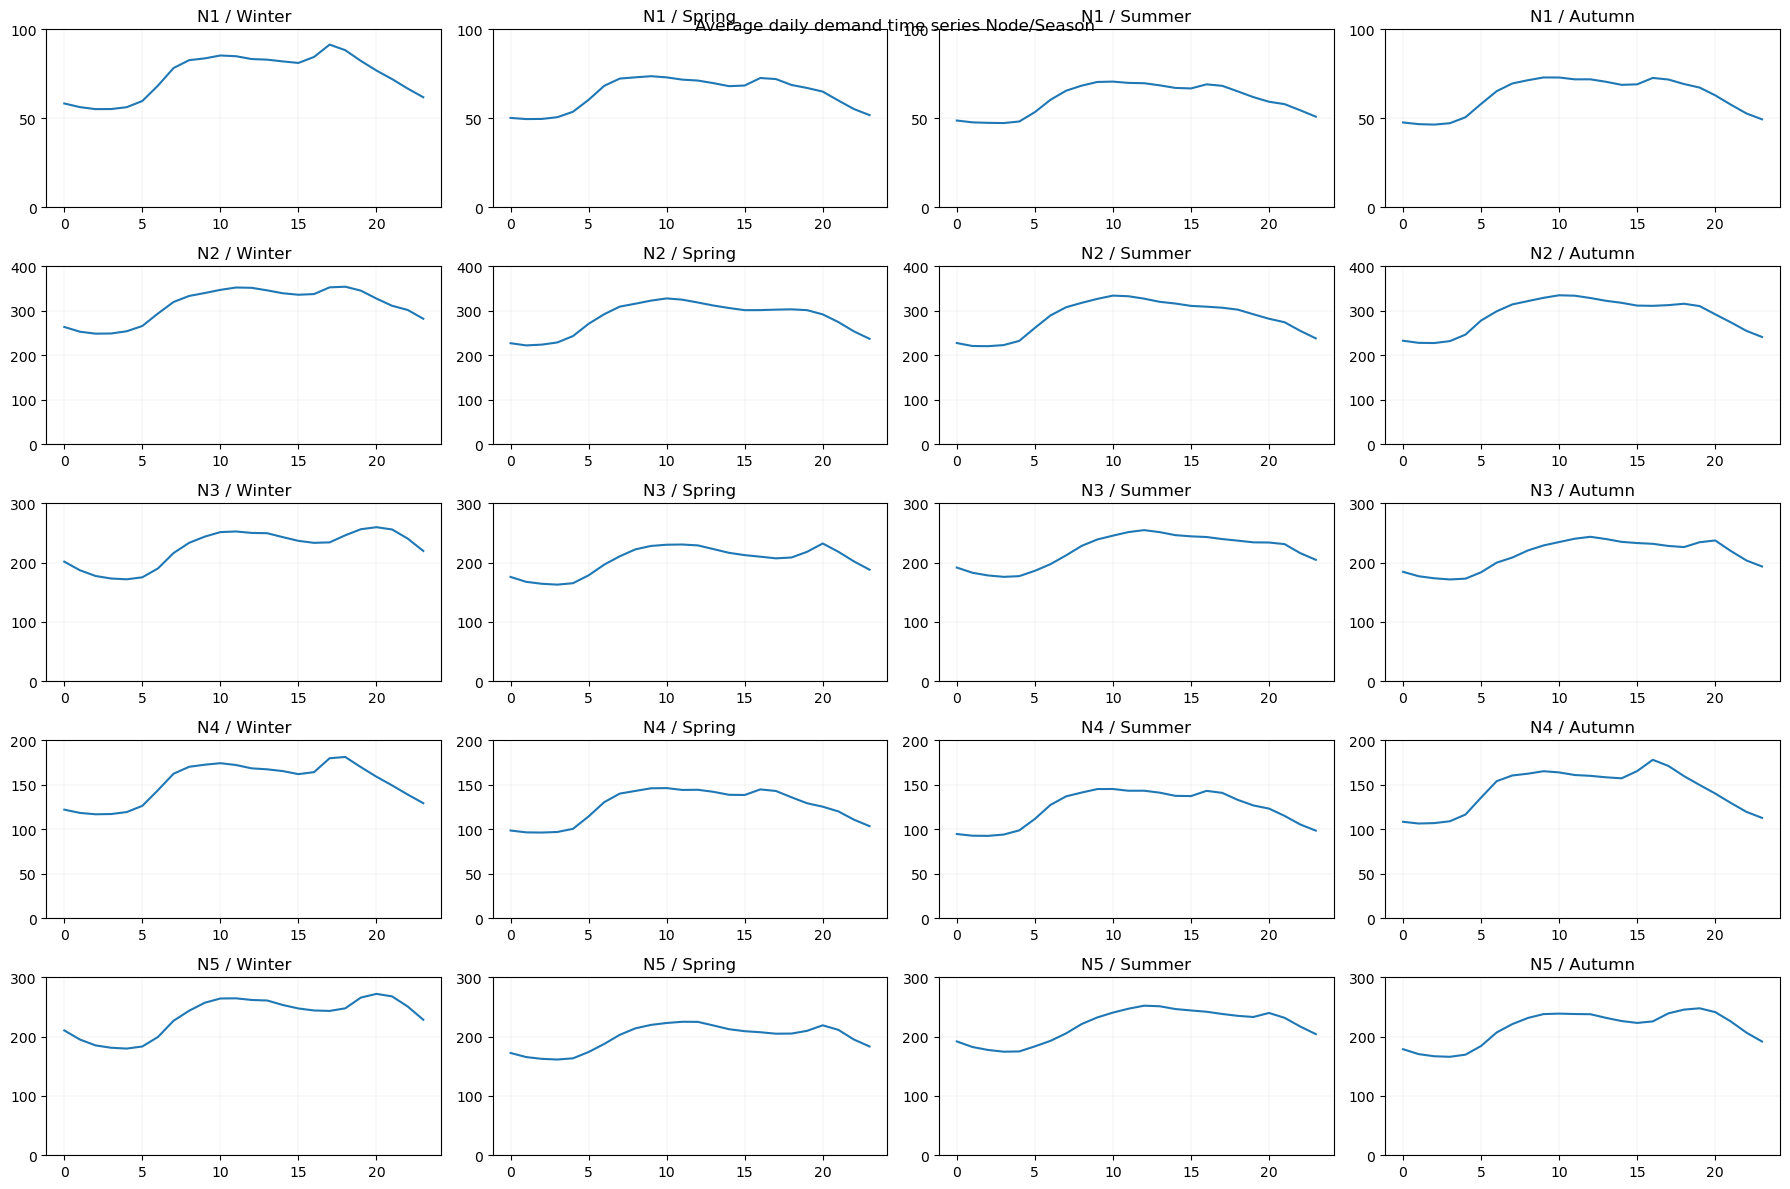

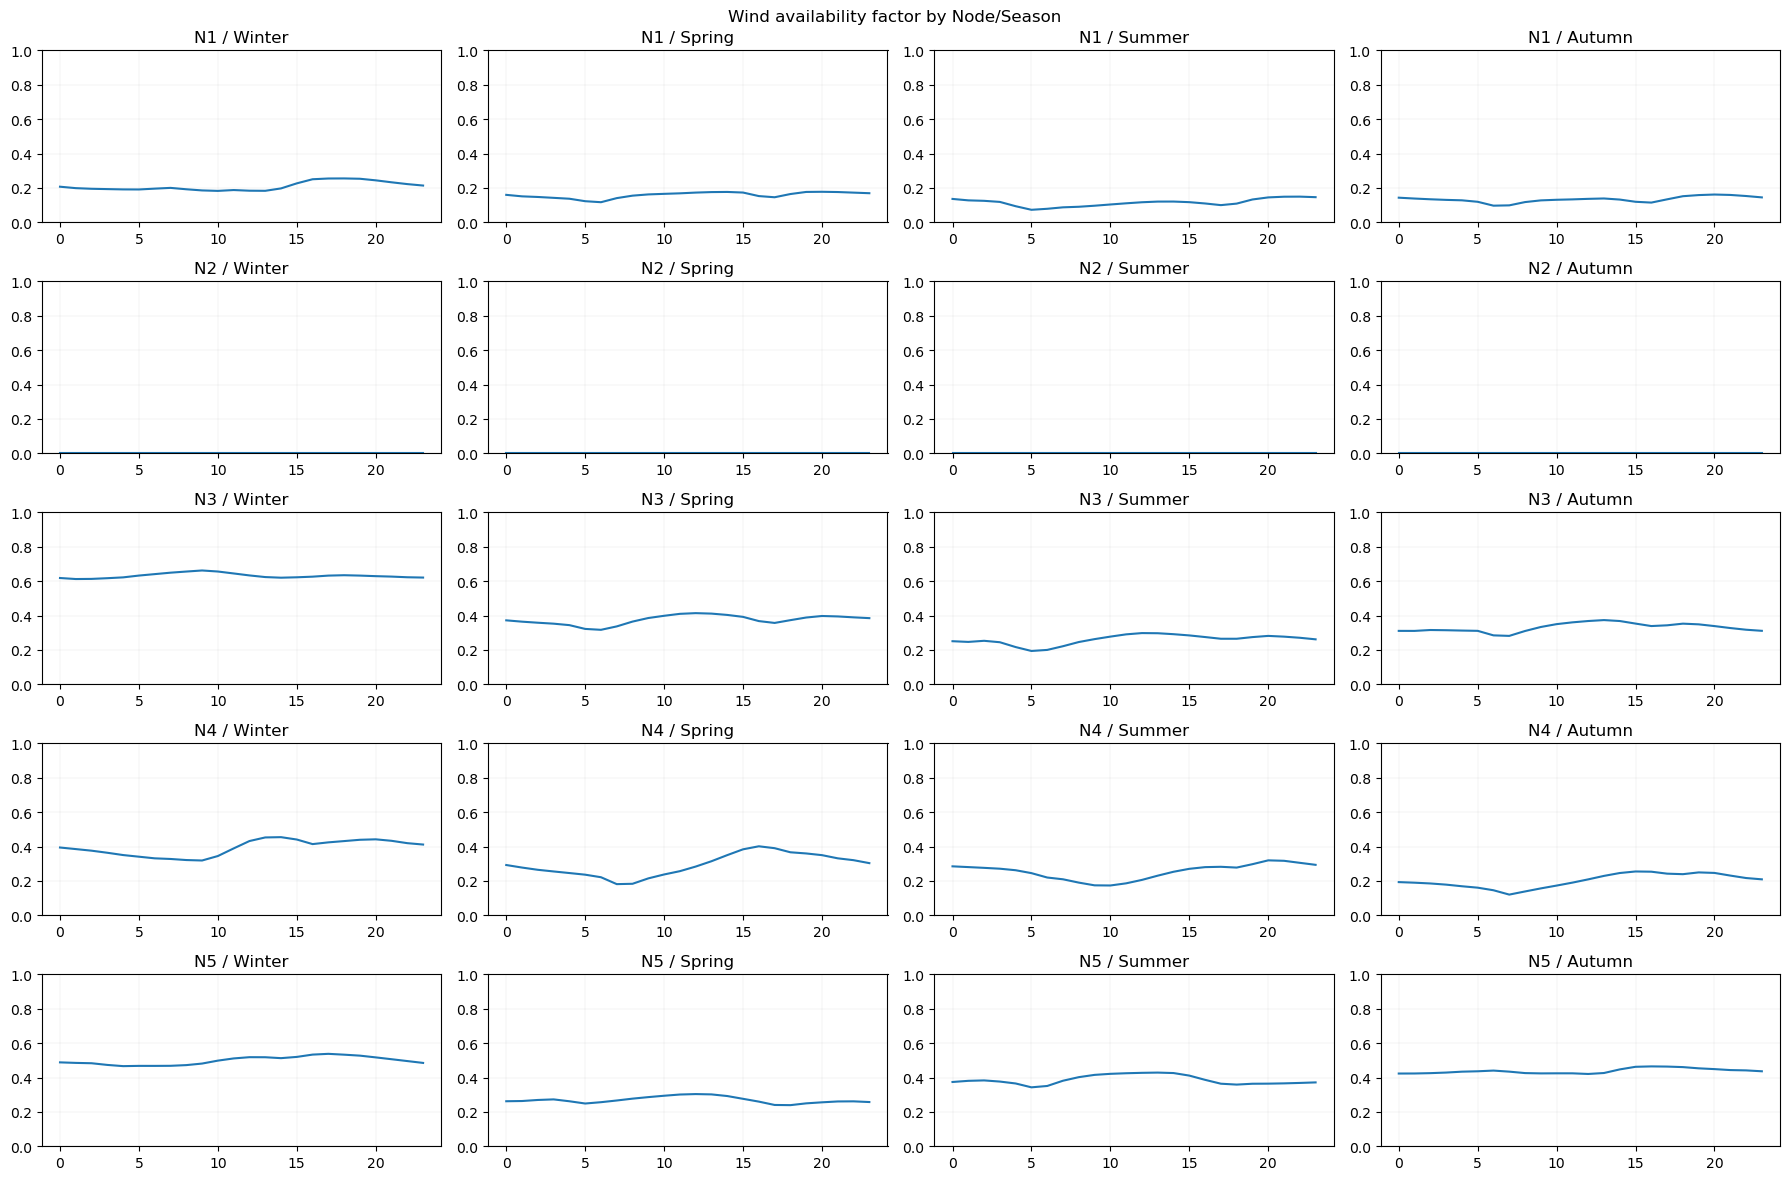

In [ ]:
# Load & preprocess deterministic data
max_load = np.array([100, 400, 300, 200, 300], dtype=float)         # The demand data is originally normalised based on a maximum load (in MW) for the location. 
demand_raw, wind_raw = read_input_data("Data")
D = np.zeros((5, 24, 4))        # Create the demand matrix for the deterministic case; dimensions: (node, hour, season)
W = np.zeros((5, 24, 4))        # Create the wind availability factor matrix for the deterministic case
for i in range(5):
    for j in range(4):
        ## The demand considered is equal to the normalised demand of the node times its maximum load.
        D[i, :, j] = max_load[i] * demand_raw[i, :, j, 1]   # 1 = Only mean values
        
        ## Wind availability is a value ranging from 0 to 1 denoting how much of the 
        ## available generation capacity can be used in each node per hour per season
        W[i, :, j] = wind_raw[i, :, j, 1]

# Quick plots
fig, axes = plt.subplots(5, 4, figsize=(18, 12)); axes = axes.ravel()   # KK: changed x and y dimensions to match data
node_labels   = ["N1", "N2", "N3", "N4", "N5"]
season_labels = ["Winter", "Spring", "Summer", "Autumn"]
idx = 0
for i, nlab in enumerate(node_labels):          # KK: Returns index i and value nlab
    for j, slab in enumerate(season_labels):
        ax = axes[idx]; ax.plot(D[i, :, j]); ax.set_title(f"{nlab} / {slab}")
        ax.set_ylim(0, max_load[i]); ax.grid(linewidth=0.1)
        ax.set_yticks(np.arange(0, max_load[i] + 1e-9, 100 if i in [1,2,4] else 50)); idx += 1
fig.suptitle("Average daily demand time series Node/Season")    # KK:Added title
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(5, 4, figsize=(18, 12)); axes = axes.ravel(); idx = 0
for i, nlab in enumerate(node_labels):
    for j, slab in enumerate(season_labels):
        ax = axes[idx]; ax.plot(W[i, :, j]); ax.set_title(f"{nlab} / {slab}")
        ax.set_ylim(0, 1); ax.grid(linewidth=0.1); idx += 1
fig.suptitle("Wind availability factor by Node/Season")     # KK:Added title
plt.tight_layout(); plt.show()


In [ ]:
# Sets & parameters
nodes = 5                       # Number of nodes considered      
N = list(range(1, nodes+1))     # Nodes set
H = list(range(1, 24+1))        # Hours in the day {1,...,24} (time periods in the model in each representative day)
S = list(range(1, 4+1))         # Seasons: 1 = "Winter",2 = "Spring",3 = "Summer",4 = "Autumn"
T = list(range(1, 5+1))         # Generation Technologies: # 1: Wind, 2: Nuclear; 3: Coal, 4: Gas OCGT, 5: Gas CCGT
L = list(combinations(range(1, nodes+1), 2))    # Lines set (list of tuples [i,j]) - generate all combinations (i,j) once
# KK: L = [(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
SS = [92, 91, 91, 91]           # Number of days in each season (used to calculate costs correctly)
season_days = lambda s: SS[s-1]
line_index = {l: i for i, l in enumerate(L)}

## Parameters (energy generation)

KI = np.array([1500.0, 3000.0, 1000.0, 500.0, 800.0])       # Generation investment cost [k€/MW]
LT = np.array([25, 30, 40, 40, 50])                         # Generation technology lifetime [years]
K  = KI * 0.05 / (1 - (1.05 ** (-LT)))                      # Annualized generation investment cost (interest rate of 5% pa)[k€/MW]
KA = np.array([60.0, 50.0, 48.0, 10.0, 16.0])               # Generation maintenance cost [k€/MW]
CO = np.array([0.1, 6.2, 13.0, 23.0, 20.0]) / 1000          # Generation operational cost [k€/MWh]
CS = 1.0        # Shedding cost [k€/MWh]
ShC = 0.1       # Shedding limit [% of demand]
RES = 0.25      # Mininum renewable energy share (for all nodes)

## Existing generation capacity (t: technologies x n: nodes); N1 and N2 start with initial nuclear capacity.
GCN = np.array([
    [0, 0, 0, 0, 0],    # KK: Wind
    [30, 60, 0, 0, 0],  # KK: Nuclear
    [0, 0, 0, 0, 0],    # KK: Coal
    [0, 0, 0, 0, 0],    # KK: Gas OCGT
    [0, 0, 0, 0, 0],    # KK: Gas CCGT
], dtype=float)

## Parameters (transmission)

KIT = 0.5                                                   # Line investment cost (also per km) [k€/MW.km]
dist = np.array([200, 400, 300,                             # Length in km of each line (i.e, [1,2], [1,3]..., [4,5], in order) 
                800, 200, 700,                              # (see L defined above for the full ordering if necessary)
                500, 750, 350, 180], dtype=float)
LT_T = 40                                                   # Transmission line lifetime [years]
KT_per_line = KIT * dist * 0.05 / (1 - (1.05 ** (-LT_T)))   # Annualized transmission investment cost (interest rate of 5% pa)[k€/MW]  
KAT = 0.01                                                  # Transmission maintenance cost [k€/MW] 
COT = 1e-4                                                  # Transmission operational cost [k€/MWh]

def D_val(n,h,s): return D[n-1, h-1, s-1]
def W_val(n,h,s): return W[n-1, h-1, s-1]


In [21]:
for i in range(len(KT_per_line)):
    print(L[i], round(KT_per_line[i],2))

(1, 2) 5.83
(1, 3) 11.66
(1, 4) 8.74
(1, 5) 23.31
(2, 3) 5.83
(2, 4) 20.4
(2, 5) 14.57
(3, 4) 21.85
(3, 5) 10.2
(4, 5) 5.25


## Task 1
The deterministic model

In [ ]:
# IMPORTANT INDEXING NOTE (READ CAREFULLY!)
# -----------------------------------------
# PuLP variables (p, p_max, q, f, ...) are NOT NumPy arrays.
# They are dictionaries indexed by the ELEMENTS of the sets T, N, H, S. // KK: Technologies, Nodes, Hours, Seasons
#
# Example:
#   p_max[t][n]     uses t ∈ {1,2,3,4,5} and n ∈ {1,...,5}
#
# In contrast, data like GCN, D, W are stored as NumPy arrays,      // KK: Generation Capacity Nodes, Demand, Wind
# which use 0-based indexing.
#
# Example:
#   GCN[t-1, n-1]   corresponds to technology t at node n
#
# Therefore, when combining DATA with DECISION VARIABLES:
#
# Correct indexing:
#   x[t][n] <= data_array[t-1, n-1] + y[t][n]
#
# WRONG indexing:
#   x[t][n] <= data_array[t, n] + y[t][n]
#
# Rule of thumb:
#   - PuLP variables  → use set indices (t, n, h, s)
#   - NumPy arrays   → use shifted indices (t-1, n-1, h-1, s-1)
#
# If you mix this up, your model will still run,
# but it will represent the WRONG mathematical problem.


# Deterministic model (PuLP)
def build_det_model_pulp():
    m = pulp.LpProblem("GTEP_Deterministic", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S), lowBound=0)        # Generation level in each hour by t [MWh]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),        lowBound=0)       # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S),     lowBound=0)       # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S),     lowBound=None)    # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S),     lowBound=0)       # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),          lowBound=0)       # Additional transmission capac. of l [MW]

    ## Objective function: total system cost comprised of:
    ## 1. Generation capacity investment costs (fixed and variable)
    ## 2. Generation operational costs
    ## 3. Transmission capacity investment costs
    ## 4. Transmission operational costs
    ## 5. Shedding costs

    gen_invest = # TODO
    trans_invest = # TODO
    gen_oper = # TODO
    trans_oper = # TODO
    shed_cost = # TODO
    m += gen_invest + trans_invest + gen_oper + trans_oper + shed_cost

    ## Constraints
    ## 1) Energy balance: at each node, hour and season the total generation of electricity plus electricity input from
    ## transmission has to be the same as the electricity used to satisfy the demand (minus the shedding amount) plus the electricity output for transmission
    for h in H:
        for n in N:
            for s in S:
                # TODO but keep the following after the constraint: , f"bal_{h}_{n}_{s}"
                # KEEP: ", f"bal_{h}_{n}_{s}".
                # We need a name to obtain the dual variable/shadow price.
                # Example:
                #   m += x + y == 10, f"constraint_name"
                #   dual = m.constraints["constraint_name"].pi   # ← marginal value (= price)
                # We name this constraint because the dual/shadow price comes from its .pi value.
                # If unnamed, students cannot compute electricity prices from the solution.

    ## 2) Renewable (wind) generation capacity: wind generation is limited by the available capacity (pre-existent + to be built) times the 
    ## wind availability factor.
    for h in H:
        for n in N:
            for s in S:
                # TODO

    ## 3) Nonrenewable generation capacity: electricity generation cannot be greater than available capacity (pre-existent + build)
    for t in [2,3,4,5]:
        for h in H:
            for n in N:
                for s in S:
                    # TODO

    ## 4) Minimum renewable energy generation: a certain percentage (RES) of the total electricity generation has to be done by renewable sources
    total_ren = # TODO
    total_gen = # TODO
    m += # TODO

    ## 5) Shedding limit: at any given hour, the total demand shed cannot exceed a fration (ShC) of the demand.
    for h in H:
        for n in N:
            for s in S:
                # TODO

    ## 6) Transmission capacity: the total energy transmitted cannot exceed the transmission capacity. Both direct (+) and inverse (-) flows 
    ## are subject to capacity limitations.
    ## 7 ) Absolute value of f[h,l,s]: a linearisation of the absolute value function must be performed to the correct value of the flow
    ## is captured in the objective function. 
    for h in H:
        for l in L:
            for s in S:
                # TODO
                # TODO
                # TODO
                # TODO

    return m, (p, p_max, q, f, f_abs, f_max)

m_det, (p, p_max, q, f, f_abs, f_max) = build_det_model_pulp()

# Use CBC as LP solver to get duals
solver = pulp.PULP_CBC_CMD(msg=False, mip=False)
m_det.solve(solver)


lam = np.zeros((len(H), len(N), len(S)))
for h in H:
    for n in N:
        for s in S:
            cname = f"bal_{h}_{n}_{s}"
            lam[h-1, n-1, s-1] = m_det.constraints[cname].pi

sol_p_max_det = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_det[t-1, n-1] = pulp.value(p_max[t][n])

sol_f_max_det = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_det[i] = pulp.value(f_max[l])
    
sol_p = np.zeros((len(T), len(H), len(N), len(S)))
for ti,t in enumerate(T):
    for hi,h in enumerate(H):
        for ni,n in enumerate(N):
            for si,s in enumerate(S):
                sol_p[ti,hi,ni,si] = pulp.value(p[t][h][n][s])


dual_vals = lam.flatten() 

mean_price = np.mean(dual_vals)
std_price  = np.std(dual_vals)
max_price  = np.max(dual_vals)
min_price  = np.min(dual_vals)  

## Analyzing the solution of the deterministic model

Here are some examples of questions that can be answered with information from the optimisation model.

1.a) "What was the generation capacity per technology per node installed? What was the transmission capacity installed?"

In [ ]:
print("Capacities installed (Tech x Node):")
print(np.round(sol_p_max_det, 2))
print("\nTransmission capacities (per line):")
print(np.round(sol_f_max_det, 2))

1.b) "What is the average price for electricity?

In [ ]:
print("\nHourly price statistics:")
print(f"- Mean price per MWh: {mean_price:.2f}")
print(f"- Standard deviation: {std_price:.2f}")
print(f"- Max price per MWh: {max_price:.2f}")
print(f"- Min price per MWh: {min_price:.2f}")

1.c) "Trade profile"

In [ ]:
sol_f = np.zeros((len(H), len(L), len(S)))
for h in H:
    for li,l in enumerate(L):
        for s in S:
            sol_f[h-1, li, s-1] = pulp.value(f[h][l][s])
            
trade_matrix = np.round(sol_f.sum(axis=0), 2)   

print("\nTrade profiles per season (Lines x Seasons):")
print(trade_matrix)
season_labels = [f"S{s}" for s in S]
line_labels   = [f"L{l}" for l in range(1, len(L)+1)]

df_trade = pd.DataFrame(trade_matrix, index=line_labels, columns=season_labels)

print("\nTrade profile table:")
print(df_trade)

1.c) "Provide any additional analysis you may find insightful to understand the systems behaviour. This could include: capacity utilisation (dispatch, i.e., energy generated divided by available capacity), energy profile for the system or per node (percentage of the energy generated by each technology), trade profile (amount of energy sent to and from each node) and so forth."

In [ ]:
print("\nDispatch in the deterministic model for Node 2 in winter:")
print(sol_p[:, :, 1, 0].T)      

In [ ]:
print("\nDispatch in the deterministic model for Node 2 in summer:")
print(np.round(sol_p[:, :, 1, 2].T, 2))


In [ ]:
sol_p = np.zeros((len(T), len(H), len(N), len(S)))  
for t in T:
    for h in H:
        for n in N:
            for s in S:
                sol_p[t-1, h-1, n-1, s-1] = pulp.value(p[t][h][n][s])
                
winter_idx = 0   
summer_idx = 2   

tech_idx  = np.arange(0, 5) 
node_idx  = np.arange(0, 5) 

diff = np.round(
    sol_p[tech_idx, :, :, summer_idx][:, :, node_idx]  
  - sol_p[tech_idx, :, :, winter_idx][:, :, node_idx], 
  2
)

A = diff.sum(axis=1)   

print("Dispatch difference in the deterministic model between Winter (S1) and Summer (S3):")
print("Rows: 1=Wind, 2=Nuclear, 3=Coal, 4=Gas OCGT, 5=Gas CCGT")
print("Cols: Nodes 1..5")
print(np.round(A, 2))

In [ ]:
node = 0          
winter = 0         
summer_idx = 2   

hours = len(H)

cap_node = sol_p_max_det[:, node] + GCN[:, node]     

unused_winter = np.sum(cap_node[:,None] - sol_p[:, :, node, winter])
summer_idx = 2    

cap_node = sol_p_max_det[:, node] + GCN[:, node]          
unused_summer = np.sum(cap_node[:,None] - sol_p[:, :, node, summer_idx])

print("\nCapacity not used in Summer (MWh):", round(unused_summer,2))
print("\nCapacity not used in Winter (MWh):", round(unused_winter,2))

## Task 2
The extended model

In [ ]:
# Modified deterministic (node RES + ramping)
RES_node = np.array([0.45, 0.45, 0.60, 0.70, 0.70])                 # Renewable energy requirement per node [% of energy production]
ramp_limit = 0.2                                                    # Relative ramping variation allowed [% of energy production]  
def build_det_model_pulp_mod():
    m = pulp.LpProblem("GTEP_Deterministic_Mod", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S), lowBound=0)        # Generation level in each hour by t [MWh]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),        lowBound=0)       # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S),     lowBound=0)       # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S),     lowBound=None)    # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S),     lowBound=0)       # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),          lowBound=0)       # Additional transmission capac. of l [MW]

    ## Objective function

    # TODO

    m += # TODO


    ## Constraints
    ## 1) Energy balance
    for h in H:
        for n in N:
            for s in S:
                 # TODO but again keep the following after the constraint: , f"bal2_{h}_{n}_{s}"

    ## 2) Renewable (wind) generation capacity
    for h in H:
        for n in N:
            for s in S:
                # TODO

    ## 3) nonrenewable generation capacity
    for t in [2,3,4,5]:
        for h in H:
            for n in N:
                for s in S:
                    # TODO

                    
    ## 4) Minimum renewable energy generation (from the deterministic model), 
    ## the total renewable energy share still has to be above 25%
    # TODO

    ## 5) Shedding cap
    for h in H:
        for n in N:
            for s in S:
                # TODO

    ## 6) Transmission cap and Absolute value of f[h][l][s]
    for h in H:
        for l in L:
            for s in S:
                # TODO

    ## Additional constraints

    ## 8) Revised constraint 4) with node-specific renewable energy shares
    for n in N:
        # TODO
        
    ## 9) Ramp-down and -up constraints
    ## For this exercise, the boundary cases do not need to be considered: there is no limit to ramping at midnight
    for t in [2,3,4,5]:
        for h in range(1,24):
            for n in N:
                for s in S:
                    # TODO

    return m, (p, p_max, q, f, f_abs, f_max)

m_det2, (p2, p_max2, q2, f2, f_abs2, f_max2) = build_det_model_pulp_mod()
solver = pulp.PULP_CBC_CMD(msg=False, mip=False)
m_det2.solve(solver)

sol_p_max_det2 = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_det2[t-1, n-1] = pulp.value(p_max2[t][n])

sol_f_max_det2 = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_det2[i] = pulp.value(f_max2[l])

lam2=np.zeros((len(H),len(N),len(S)))
for h in H:
    for n in N:
        for s in S:
            lam2[h-1,n-1,s-1]=m_det2.constraints[f"bal2_{h}_{n}_{s}"].pi

dual_vals2=lam2.flatten()


We replicate below some of the analyses of the previus task. Feel free to come up with your own to analyse the results and discuss the main differences between the models in tasks 1 and 2.

In [ ]:
print("Capacities (modified, Tech x Node):")
print(np.round(sol_p_max_det2, 2))

In [ ]:
print("\nTransmission capacities (modified):")
print(np.round(sol_f_max_det2, 2))

In [ ]:
print("P\nHourly price statistics:")
print(f"- Mean price per MWh: {dual_vals2.mean():.2f}")
print(f"- Standard deviation: {dual_vals2.std():.2f}")
print(f"- Max price per MWh: {dual_vals2.max():.2f}")
print(f"- Min price per MWh: {dual_vals2.min():.2f}")

In [ ]:
sol_p2 = np.zeros((len(T), len(H), len(N), len(S)))
for t in T:
    for h in H:
        for n in N:
            for s in S:
                sol_p2[t-1,h-1,n-1,s-1] = pulp.value(p2[t][h][n][s])

winter = 0   
summer = 2   
node   = 2   



A_full = np.round(sol_p2[:,:,:,summer] - sol_p2[:,:,:,winter], 2).sum(axis=1)  

print("\nDispatch difference in the deterministic model for N3 between Winter and Summer was: ")
print(np.round(A_full,2))

In [ ]:
sol_f_det2 = np.zeros((len(H), len(L), len(S)))

for hi, h in enumerate(H):
    for li, l in enumerate(L):
        for si, s in enumerate(S):
            sol_f_det2[hi, li, si] = pulp.value(f2[h][l][s])
flows_line10 = np.sum(np.round(sol_f_det2[:, 9, :], 2))

print("\nTransmission flows installed in the deterministic model (Line 10):")
print(round(flows_line10,2))

In [ ]:
A = np.round(sol_f_det2,2).sum(axis=0)   

print("\nTrade profiles:")
np.set_printoptions(suppress=True, precision=4)  
print(A)

## Task 3
The stochastic model

In [ ]:
# Stochastic model (expected costs)
# First we need to create the set representing the scenarios, augment the parameters with wind and demand data, and finally provide the probability of each scenario.

SC = [1,2,3]    # Sc 1="Pessimistic" (min. value); 2="Expected" (mean value); 3="Optimistic" (max. value)

## Augmenting wind and demand data for the stochastic model
D_sto = np.zeros((5,24,4,3))    # Dimensions: (node, hour, season, scenario)
W_sto = np.zeros((5,24,4,3))  
_demand_raw, _wind_raw = read_input_data("Data")
for i in range(5):      # Node
    for j in range(4):  # Season

        ## Pessimistic
        D_sto[i,:,j,0] = max_load[i] * _demand_raw[i,:,j,2]
        W_sto[i,:,j,0] = _wind_raw[i,:,j,0]

        ## Expected
        D_sto[i,:,j,1] = max_load[i] * _demand_raw[i,:,j,1]
        W_sto[i,:,j,1] = _wind_raw[i,:,j,1]

        ## Optimistic
        D_sto[i,:,j,2] = max_load[i] * _demand_raw[i,:,j,0]
        W_sto[i,:,j,2] = _wind_raw[i,:,j,2]

## Probability distribution for scenarios (1 - pessimist, 2 - average, 3 - optimistic)
Pr = np.array([0.25,0.5,0.25])

def D_s(n,h,s,sc): return D_sto[n-1, h-1, s-1, sc-1]
def W_s(n,h,s,sc): return W_sto[n-1, h-1, s-1, sc-1]




In [ ]:
def build_sto_model_pulp(Pr_vec):
    m = pulp.LpProblem("GTEP_Stochastic", pulp.LpMinimize)
    p     = pulp.LpVariable.dicts("p",     (T, H, N, S, SC), lowBound=0)        # Generation level in each hour by t [MW]
    p_max = pulp.LpVariable.dicts("p_max", (T, N),           lowBound=0)        # Additional generation capac. of t [MW]
    q     = pulp.LpVariable.dicts("q",     (H, N, S, SC),    lowBound=0)        # Energy shedding in h [MWh]
    f     = pulp.LpVariable.dicts("f",     (H, L, S, SC),    lowBound=None)     # Transmission flow in each hour by t [MWh]
    f_abs = pulp.LpVariable.dicts("f_abs", (H, L, S, SC),    lowBound=0)        # Auxiliary variable for calculating |f[h,l,s]|
    f_max = pulp.LpVariable.dicts("f_max", (L,),             lowBound=0)        # Additional transmission capac. of t [MW]


    ## Objective function
    # TODO
    m += # TODO


    ## Constraints

    ## 1) Energy balance
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO keep the following after the constraint: , f"bal_sto_{h}_{n}_{s}_{sc}"


    ## 2) Wind generation capacity
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO

    ## 3) Nonrenewable generation capacity
    for t in [2,3,4,5]:
        for h in H:
            for n in N:
                for s in S:
                    for sc in SC:
                        # TODO

    ## 4) Minimum renewable energy generation
    for sc in SC:
        # TODO

    ## 5) Shedding cap
    for h in H:
        for n in N:
            for s in S:
                for sc in SC:
                    # TODO

    ## 6) Transmission cap and absolute value of f[h][l][s][sc]
    for h in H:
        for l in L:
            for s in S:
                for sc in SC:
                    # TODO

    return m, (p, p_max, q, f, f_abs, f_max)

m_sto, (ps, pmaxs, qs, fs, fabs_s, fmaxs) = build_sto_model_pulp(Pr)
m_sto.solve(solver)

sol_p_max_sto = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_sto[t-1, n-1] = pulp.value(pmaxs[t][n])

sol_f_max_sto = np.zeros(len(L))
for i,l in enumerate(L):
    sol_f_max_sto[i] = pulp.value(fmaxs[l])
    
lam_sto = np.zeros((len(H), len(N), len(S), len(SC)))

for h in H:
    for n in N:
        for s in S:
            for sc in SC:
                cname = f"bal_sto_{h}_{n}_{s}_{sc}"
                lam_sto[h-1,n-1,s-1,sc-1] = m_sto.constraints[cname].pi

prices_all = lam_sto.flatten()

sol_q_sto = np.zeros((len(H), len(N), len(S), len(SC)))
for hi,h in enumerate(H):
    for ni,n in enumerate(N):
        for si,s in enumerate(S):
            for sci,sc in enumerate(SC):
                sol_q_sto[hi,ni,si,sci] = pulp.value(qs[h][n][s][sc])
                
shortages = sol_q_sto[sol_q_sto > 0]              
shortages_rounded = np.round(shortages, 2)

New_Pr = np.array([0.60, 0.30, 0.10])
m_sto2, (ps2, pmaxs2, qs2, fs2, fabs2, fmaxs2) = build_sto_model_pulp(New_Pr)
m_sto2.solve(solver)

sol_p_max_sto2 = np.zeros((len(T), len(N)))
for t in T:
    for n in N:
        sol_p_max_sto2[t-1, n-1] = pulp.value(pmaxs2[t][n])


Here are once more suggestions for comparing the model with the deterministic version

"What was the generation capacity installed per technology per node? What was the transmission capacity installed?"

In [ ]:
print("Capacities installed (stochastic):")
print(np.round(sol_p_max_sto, 2))

In [ ]:
print("\nDiff vs deterministic (generation caps):")
print(np.round(sol_p_max_sto - sol_p_max_det, 2))

In [ ]:
print("\nDiff vs deterministic (transmission caps):")
print(np.round(sol_f_max_sto - sol_f_max_det, 2))

In [ ]:
print("\nOccurrence of shortage:")
print(shortages_rounded)

In [ ]:
# Probability sensitivity
print("New capacities (stochastic, New_Pr):")
print(np.round(sol_p_max_sto2, 2))
print("\nDifferences vs baseline stochastic:")
print(np.round(sol_p_max_sto2 - sol_p_max_sto, 2))


In [ ]:
print("P\nHourly price statistics:")
print(f"- Mean price per MWh:  {prices_all.mean():.2f}")
print(f"- Standard deviation: {prices_all.std():.2f}")
print(f"- Max price per MWh: {prices_all.max():.2f}")
print(f"- Min price per MWh:: {prices_all.min():.2f}")

# Expected nodal price (prob. weighted)
exp_price_node = (lam_sto * Pr.reshape(1,1,1,-1)).sum(axis=3).mean(axis=(0,2))
print("\nExpected nodal price by node:", np.round(exp_price_node,2))